# Alerting ictality of EEG clip
Noam Siegel, Ben Gurion University

In [173]:
# imports
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
from matplotlib.colors import LogNorm
from mlxtend.plotting import plot_decision_regions
from pytorch_lightning import seed_everything
from sklearn import preprocessing, svm, mixture
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from msc.dataset import DogDataset
from msc.models import multiChannelEEGGPModel
from msc.results_collectors import GPResultsCollector

seed_everything(42)
%load_ext autoreload
%autoreload 2

Global seed set to 42


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load embeddings

getting page=1/1


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


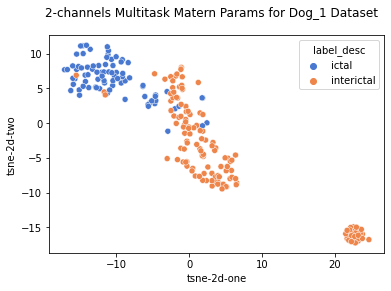

In [174]:
 # get results of multitask (pair) GP params MLE
requested_project_name = "inference/pairs"
requested_params = ['covar_module.data_covar_module.base_kernel.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

results_df = GPResultsCollector(requested_project_name, requested_params, n_pages=1).results_df

# get parameter values
X = results_df[requested_params].values

# calculate t-SNE values of parameters
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

# add t-SNE results to results_df
results_df['tsne-2d-one'] = tsne_results[:, 0]
results_df['tsne-2d-two'] = tsne_results[:, 1]

# plot t-sne results
sns.scatterplot(data=results_df,
              x='tsne-2d-one', y='tsne-2d-two',
              # hue_order=hue_order,
              hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")
plt.show()

## Estimate interictal embeddings density

In [175]:
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(X)

GaussianMixture(n_components=2)

## Load new data clip

In [190]:
# load dataset
dataset_dir = r"C:\Users\noam\Repositories\noamsgl\msc\data\seizure-detection\Dog_1"
dataset = DogDataset(dataset_dir)

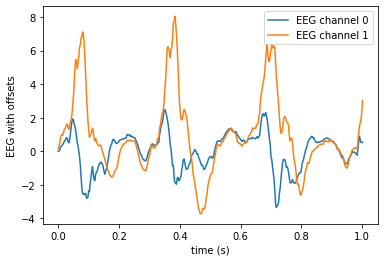

In [219]:
# set number of channels
num_channels = 2

# sample clip from dataset
train_x, train_y = dataset.sample_clip(num_channels, label_desc="ictal")

# plot clip with offsets
for i in range(train_y.size(-1)):
    plt.plot(train_x, train_y[..., i] + i, label=f"EEG channel {i}")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("EEG with offsets")
plt.show()

## Compute clip embedding
We embed the clip in the space of Gaussian process (GP) parameters.


In [220]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_channels)
model = multiChannelEEGGPModel(train_x, train_y, likelihood, num_channels)

In [221]:
smoke_test = False
training_iterations = 2 if smoke_test else 1000

# move to GPU
assert torch.cuda.is_available()
train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

# set model and likelihood to training mode
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

In [222]:
requested_params_new = ['covar_module.data_covar_module.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

In [223]:
params_df = pd.DataFrame(model.get_params_dict(), index=[0])

In [224]:
embedding = params_df[requested_params_new].to_numpy()

## Compute ictality of clip

In [225]:
# compute negative log likelihood of clip embedding
ictality = -gmm.score(embedding)

In [226]:
# compute tail area probability (p-value) of clip
results_df["nll"] = results_df.apply(lambda row: -gmm.score(np.array(row[requested_params]).reshape(1,-1)), axis=1)
results_df

,id_task,company,user,name_task,type,status,status_reason,status_message,status_changed,comment,...,covar_module.task_covar_module.covar_factor[0],covar_module.task_covar_module.covar_factor[1],covar_module.task_covar_module.raw_var[0],covar_module.task_covar_module.raw_var[1],id_project,name_project,label_desc,tsne-2d-one,tsne-2d-two,nll
0,d19c977b64684f9d82cfa0084901ef6f,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c001', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T12:03:34.592000+00:00,Auto-generated at 2022-02-02 12:01:42 UTC by n...,...,-0.570245,-0.212416,-1.749315,-0.920578,0747e1681f614bedac05f82fe42fa48a,inference/pairs/Dog_1_ictal_segment_1.mat,ictal,-11.176705,4.313467,4.386723
1,a09cc93d8cf449d999e63a6a081fc4cd,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c003', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T12:05:34.277000+00:00,Auto-generated at 2022-02-02 12:03:34 UTC by n...,...,-0.408791,-0.692524,-0.923096,-1.005680,0747e1681f614bedac05f82fe42fa48a,inference/pairs/Dog_1_ictal_segment_1.mat,ictal,-12.238815,4.964213,4.558466
3,fad2c02433d545bba7733503519c87f1,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c005', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T12:07:59.885000+00:00,Auto-generated at 2022-02-02 12:05:34 UTC by n...,...,-0.627055,-0.635098,-2.228269,-1.859585,0747e1681f614bedac05f82fe42fa48a,inference/pairs/Dog_1_ictal_segment_1.mat,ictal,-1.928401,2.065002,4.180273
4,509a24df6e8d433b85993b2815a8c902,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c007', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T12:10:25.436000+00:00,Auto-generated at 2022-02-02 12:08:00 UTC by n...,...,-1.423662,-0.255829,0.726123,0.289481,0747e1681f614bedac05f82fe42fa48a,inference/pairs/Dog_1_ictal_segment_1.mat,ictal,-15.630742,6.400676,6.895902
5,6d4f7673a530466fb39a9c2598222436,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c009', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T12:12:54.036000+00:00,Auto-generated at 2022-02-02 12:10:25 UTC by n...,...,0.086742,-0.719742,0.926390,-0.764195,0747e1681f614bedac05f82fe42fa48a,inference/pairs/Dog_1_ictal_segment_1.mat,ictal,-15.046614,4.781668,7.522007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,a69576aaf79a4a0b9977dc5b9056685a,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c007', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T15:07:09.295000+00:00,Auto-generated at 2022-02-02 15:05:27 UTC by n...,...,0.349365,0.128788,-4.230953,-2.990900,e2a8eb350f804d0783950fd35c625af2,inference/pairs/Dog_1_interictal_segment_112.mat,interictal,0.412866,-6.887066,4.872592
216,52b95a71807440fa90fdbb11a331f20d,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c009', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T15:08:52.918000+00:00,Auto-generated at 2022-02-02 15:07:09 UTC by n...,...,0.309201,0.060063,-3.371378,-2.398291,e2a8eb350f804d0783950fd35c625af2,inference/pairs/Dog_1_interictal_segment_112.mat,interictal,-0.657473,-3.737061,4.546874
217,704b423997c3411cb5ac945376163f7e,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c011', 'NVC0905_22_00...",training,completed,completed,,2022-02-02T15:10:32.349000+00:00,Auto-generated at 2022-02-02 15:08:53 UTC by n...,...,-0.371303,-0.003334,-2.323230,-1.633553,e2a8eb350f804d0783950fd35c625af2,inference/pairs/Dog_1_interictal_segment_112.mat,interictal,-0.124655,1.711347,4.504009
218,fa656e5fd34540fd8a1f7e562e0978bf,1d753395b88f4d43881241ef78f833f5,daf2f6a2f4a947ed9a1dd87f2814dd6a,"gp_['NVC0905_22_002_Ecog_c013', 'NVC0905_22_00...",training,completed,comple

p_value=0.9398148148148148


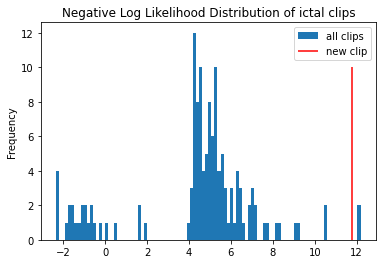

In [227]:
results_df.loc[results_df['label_desc'] == 'interictal', "nll"].plot(kind="hist", bins=100, label="all clips")
plt.vlines(ictality, 0, 10, colors="r", label="new clip")
plt.legend()
plt.title("Negative Log Likelihood Distribution of ictal clips")
p_value = (len(results_df[results_df["nll"] < ictality]))/(len(results_df))
print(f"{p_value=}")